<a href="https://colab.research.google.com/github/BhaktiGajipara/LLM/blob/main/Transfer_learning_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [2]:
!kaggle datasets download -d salader/dogs-vs-cats

Dataset URL: https://www.kaggle.com/datasets/salader/dogs-vs-cats
License(s): unknown
100% 1.06G/1.06G [00:51<00:00, 22.3MB/s]
100% 1.06G/1.06G [00:51<00:00, 22.0MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
import tensorflow
from tensorflow import keras
from keras.src.utils import image_dataset
from keras import Sequential
from keras.layers import Flatten,Dense
from keras.applications.vgg16 import VGG16

In [5]:
conv_base = VGG16(
    weights = "imagenet",
    include_top = False,
    input_shape = (150,150,3))

58889256/58889256 [==============================] - 4s 0us/step


In [7]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [8]:
conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

for layer in conv_base.layers:
  print(layer.name,layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [9]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [10]:
model = Sequential()

model.add(conv_base)
model.add(Flatten())
model.add(Dense(256,activation = "relu"))
model.add(Dense(1,activation = "sigmoid"))

In [11]:
# generator
train_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/train',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 32,
    image_size = (150,150)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/test',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 32,
    image_size = (150,150)
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


In [12]:
# Normalize
def process(image,label):
  image = tensorflow.cast(image/255. ,tensorflow.float32)
  return image,label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

In [13]:
model.compile(
    optimizer = keras.optimizers.RMSprop(learning_rate=1e-5) ,
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

In [14]:
history = model.fit(train_ds,epochs = 10,validation_data = validation_ds)

Epoch 1/10
625/625 [==============================] - 82s 119ms/step - loss: 0.2369 - accuracy: 0.9014 - val_loss: 0.1935 - val_accuracy: 0.9132
Epoch 2/10
625/625 [==============================] - 76s 121ms/step - loss: 0.1368 - accuracy: 0.9461 - val_loss: 0.1316 - val_accuracy: 0.9476
Epoch 3/10
625/625 [==============================] - 77s 122ms/step - loss: 0.0982 - accuracy: 0.9635 - val_loss: 0.1237 - val_accuracy: 0.9520
Epoch 4/10
625/625 [==============================] - 77s 123ms/step - loss: 0.0698 - accuracy: 0.9747 - val_loss: 0.1194 - val_accuracy: 0.9536
Epoch 5/10
625/625 [==============================] - 68s 108ms/step - loss: 0.0472 - accuracy: 0.9846 - val_loss: 0.1368 - val_accuracy: 0.9462
Epoch 6/10
625/625 [==============================] - 67s 107ms/step - loss: 0.0324 - accuracy: 0.9908 - val_loss: 0.1231 - val_accuracy: 0.9548
Epoch 7/10
625/625 [==============================] - 68s 108ms/step - loss: 0.0208 - accuracy: 0.9945 - val_loss: 0.1303 - val_ac

In [15]:
model.save('transfer_learning_fine_tuning.keras')

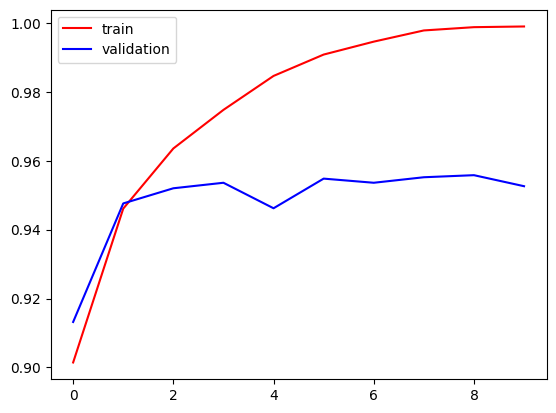

In [16]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color = "red" ,label = "train")
plt.plot(history.history['val_accuracy'],color = "blue", label = "validation")
plt.legend()
plt.show()

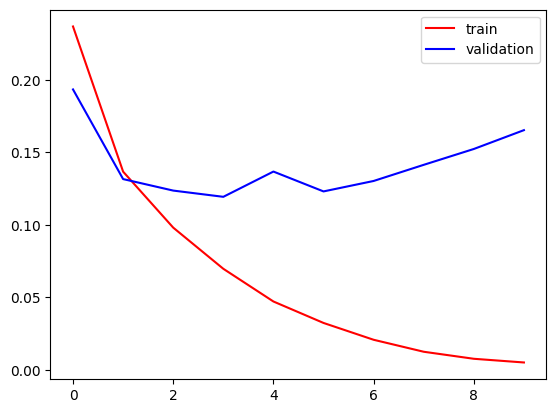

In [17]:
plt.plot(history.history['loss'],color = "red" ,label = "train")
plt.plot(history.history['val_loss'],color = "blue", label = "validation")
plt.legend()
plt.show()